# Optimize parameters of reduced morphology model 

Reduction method is Marasco method, 7 folding passes.

In [1]:
# Enable interactive plots with backend 'notebook'
%matplotlib notebook

# Enable connecting with ipyton console --existing
# %connect_info

# print code version (hash of checked out version)
!git log -1

# print date and time of script execution
import datetime
print("\nNotebook executed at at {} in following directory:".format(datetime.datetime.now()))
%cd ..
%pwd

commit c3518abba69ae2057ca96166fd0b25f17036da4a (HEAD -> nothreadsafe, origin/nothreadsafe)
Author: Lucas Koelman <lucas.koelman@gmail.com>
Date:   Thu Oct 5 19:05:44 2017 +0100

    Reduce number of features and add parallel execution

Notebook executed at at 2017-10-06 17:54:32.311892 in following directory:
/home/luye/workspace/bgcellmodels/GilliesWillshaw


u'/home/luye/workspace/bgcellmodels/GilliesWillshaw'

## Notes for running optimization

To run parallel optimization (individuals in population evaluated over many cores), the ipyprallel module can be used. To use ipyparallel you must start a controller and a number of engine (worker) instances before starting ipython (see http://ipyparallel.readthedocs.io/en/latest/intro.html), e.g:

```bash
ipcluster start -n 6
```

, where the -n argument is the number of workers / cores.
	
Make sure that Hoc can find the .hoc model files by either executing above command in the directory containing those files, or adding the relevant directories to the environment variable `$HOC_LIBRARY_PATH` (this could also be done in 
your protocol or cellmodel script using `os.environ["HOC_LIBRARY_PATH"]`)

## Run optimization

Optimize parameters of reduced model. Passive parameters should be fitted first and set in the module file. Parameters to optimize, stimulation protocols to use for evaluation (objective function), and electrophysiological features extracted from the protocol responses can be set in following modules:

```python
optimize.bpop_parameters_stn
optimize.bpop_protocols_stn
optimize.bpop_features_stn
```

In [2]:
# Import our optimization modules
from optimize.bpop_cellmodels import StnReducedModel
from optimize.bpop_optimize_stn import *

# Choose model we want to optimize
cell_model = StnReducedModel(
                name        = 'StnFolded',
                fold_method = 'marasco',
                num_passes  = 7)

# Maximum number of generations in optimization
num_generations = 10

# Checkpoints: for each generation save [population, generation, parents, halloffame, history, logbook, rndstate]
checkpoints_file = '/home/luye/cloudstore_m/simdata/marasco_folding/opt_marasco7pass_checkpoints1.pkl'

# Make optimisation
optimisation, opt_data = make_optimisation(
                            red_model = cell_model, 
                            parallel = True,
                            export_locals = False)

# Run optimisation
final_pop, hall_of_fame, logs, hist = optimisation.run(
                                        max_ngen = num_generations,
                                        cp_filename = checkpoints_file)

bluepyopt.ephys.efeatures:DEBUG:Calculated value for CLAMP_REBOUND.adaptation_index2: 0.0243086828766 @efeatures.py:177
bluepyopt.ephys.efeatures:DEBUG:Calculated value for CLAMP_REBOUND.min_AHP_values: -61.2351049487 @efeatures.py:177
bluepyopt.ephys.efeatures:DEBUG:Calculated value for CLAMP_REBOUND.Spikecount: 17.0 @efeatures.py:177
bluepyopt.ephys.efeatures:DEBUG:Calculated value for CLAMP_REBOUND.ISI_CV: 0.14756131579 @efeatures.py:177
bluepyopt.ephys.efeatures:DEBUG:Calculated value for MIN_SYN_BURST.adaptation_index2: 0.0284652329892 @efeatures.py:177
bluepyopt.ephys.efeatures:DEBUG:Calculated value for MIN_SYN_BURST.min_AHP_values: -64.4950936613 @efeatures.py:177
bluepyopt.ephys.efeatures:DEBUG:Calculated value for MIN_SYN_BURST.Spikecount: 72.0 @efeatures.py:177
bluepyopt.ephys.efeatures:DEBUG:Calculated value for MIN_SYN_BURST.ISI_CV: 1.50795735466 @efeatures.py:177


Ready for parallel execution on folowing hosts: lucas-thinkstation


__main__:INFO:gen	nevals	avg    	std    	min    	max    
1  	10    	572.671	194.517	159.089	726.201
2  	10    	604.703	258.699	112.475	1329    @algorithms.py:136
__main__:DEBUG:Wrote checkpoint to /home/luye/cloudstore_m/simdata/marasco_folding/opt_marasco7pass_checkpoints1.pkl @algorithms.py:148
__main__:INFO:3  	10    	559.213	256.236	112.475	996.672 @algorithms.py:136
__main__:DEBUG:Wrote checkpoint to /home/luye/cloudstore_m/simdata/marasco_folding/opt_marasco7pass_checkpoints1.pkl @algorithms.py:148
__main__:INFO:4  	10    	422.28 	344.194	62.3719	1134.94 @algorithms.py:136
__main__:DEBUG:Wrote checkpoint to /home/luye/cloudstore_m/simdata/marasco_folding/opt_marasco7pass_checkpoints1.pkl @algorithms.py:148
__main__:INFO:5  	10    	198.497	204.956	47.6109	707.345 @algorithms.py:136
__main__:DEBUG:Wrote checkpoint to /home/luye/cloudstore_m/simdata/marasco_folding/opt_marasco7pass_checkpoints1.pkl @algorithms.py:148
__main__:INFO:6  	10    	127.615	137.726	47.6109	709.72  @algorith

## Analyze optimization results

We want to know how our individuals (candidate parameter sets) evolved during the optimization, and potentially how their responses look.

In [ ]:
# OPTIONAL: reload previous results from checkpoints file
checkpoint = pickle.load(open(checkpoints_file, "r"))
logs = checkpoint['logbook']

<IPython.core.display.Javascript object>


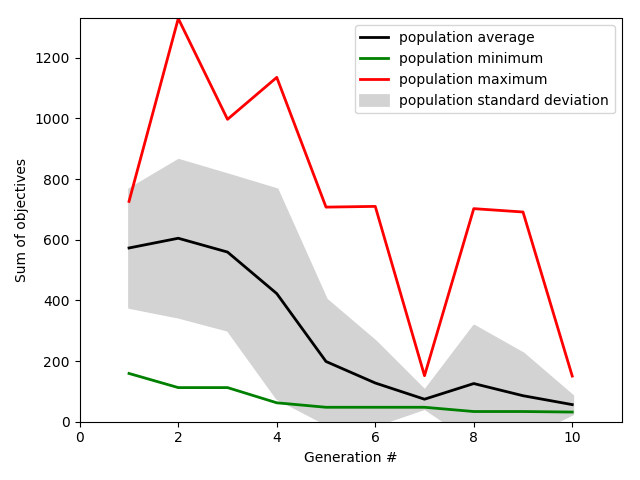

In [3]:
# Import our analysis modules
from optimize.bpop_analysis_stn import plot_log

# Plot evolution of fitness values
plot_log(logs)

## Evaluate / Validate optimization results

We want to know how our optimized model performs under other stimulation protocols that were not part of the objective function. This is a form of cross-validation.

### Plot parameters and how they evolved

In [4]:
# %load_ext autoreload
# %autoreload 2

from optimize.bpop_analysis_stn import (
    plot_responses,
    plot_fitness_scores,
    plot_diversity,
)

# Retrieve optimisation variables
# evaluator = opt_data['evaluator']
# ephys_protocols = opt_data['ephys_protocols']
evaluator = optimisation.evaluator
ephys_protocols = optimisation.evaluator.fitness_protocols

{ 'gcaL_HVA_dend_scale': 2.0708293048025253,
  'gcaN_HVA_dend_scale': 9.65761652305593,
  'gcaT_CaT_dend_scale': 6.70595802037168,
  'gk_Ih_dend_scale': 0.23734846047890074,
  'gk_sKCa_dend_scale': 5.993946579023348,
  'gna_NaL_dend_scale': 7.515756080544497}
None
1  
loading STh cell data structures...
 
1 Creating STh Neurons

22   2 trees
  loaded tree 0 (23 branches)
  loaded tree 1 (11 branches)
loading linear+uniform conductances
0.0001 0.001 Skipping soma


bluepyopt.ephys.mechanisms:DEBUG:Inserted GLUsyn at ['zipF_zipE_zipD_SThcell0dend01(0.9375)', 'zipG_zipF_zipE_zipD_SThcell0dend02(1)', 'zipG_zipF_zipE_zipD_SThcell0dend02(1)', 'zipG_zipF_zipE_zipD_SThcell0dend01(1)']  @mechanisms.py:303
bluepyopt.ephys.mechanisms:DEBUG:Inserted GABAsyn at ['SThcell[0].dend0[2](0.75)']  @mechanisms.py:303
bpop_ext:DEBUG:Scaled gna_NaL in ['dendritic'] by factor 7.51575608054 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gk_Ih in ['dendritic'] by factor 0.237348460479 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gk_sKCa in ['dendritic'] by factor 5.99394657902 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gcaT_CaT in ['dendritic'] by factor 6.70595802037 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gcaL_HVA in ['dendritic'] by factor 2.0708293048 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gcaN_HVA in ['dendritic'] by factor 9.65761652306 @bpop_extensions.py:86


Setting in vitro parameters based on Bevan & Wilson (1999)


bpop_ext:DEBUG:Adding space clamp to somatic[0](0.5) with durations [0, 0, 500], and amplitudes [0, 0, -75] @bpop_extensions.py:220
bluepyopt.ephys.recordings:DEBUG:Adding compartment recording of v at somatic[0](0.5) @recordings.py:89
bluepyopt.ephys.simulators:DEBUG:Running Neuron simulator 650 ms, with dt=0.025 @simulators.py:133
bluepyopt.ephys.simulators:DEBUG:Neuron simulation finished @simulators.py:147


1  
loading STh cell data structures...
 
1 Creating STh Neurons

22   2 trees
  loaded tree 0 (23 branches)
  loaded tree 1 (11 branches)
loading linear+uniform conductances
0.0001 0.001 Skipping soma


bluepyopt.ephys.mechanisms:DEBUG:Inserted GLUsyn at ['zipF_zipE_zipD_SThcell0dend01(0.9375)', 'zipG_zipF_zipE_zipD_SThcell0dend02(1)', 'zipG_zipF_zipE_zipD_SThcell0dend02(1)', 'zipG_zipF_zipE_zipD_SThcell0dend01(1)']  @mechanisms.py:303
bluepyopt.ephys.mechanisms:DEBUG:Inserted GABAsyn at ['SThcell[0].dend0[2](0.75)']  @mechanisms.py:303
bpop_ext:DEBUG:Scaled gna_NaL in ['dendritic'] by factor 7.51575608054 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gk_Ih in ['dendritic'] by factor 0.237348460479 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gk_sKCa in ['dendritic'] by factor 5.99394657902 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gcaT_CaT in ['dendritic'] by factor 6.70595802037 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gcaL_HVA in ['dendritic'] by factor 2.0708293048 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gcaN_HVA in ['dendritic'] by factor 9.65761652306 @bpop_extensions.py:86
bpop_ext:DEBUG:Set aCSF concentrations. @bpop_protocols_stn.py:378
bluepyopt.ephys.recordings:D

<IPython.core.display.Javascript object>


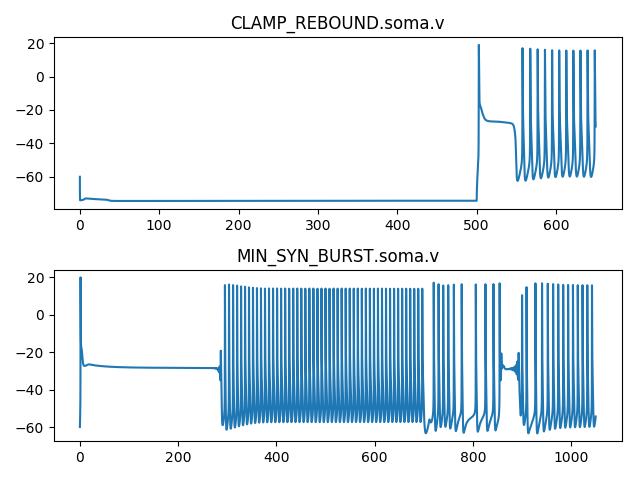

In [5]:
import pprint
pp = pprint.PrettyPrinter(indent=2)

# Print fittest individual (best parameter set)
best_params = evaluator.param_dict(hall_of_fame[0])
print(pp.pprint(best_params))

# Plot responses of best parameters
best_responses = evaluator.run_protocols(protocols=ephys_protocols.values(), param_values=best_params)
plot_responses(best_responses)

bluepyopt.ephys.efeatures:DEBUG:Calculated score for CLAMP_REBOUND.adaptation_index2: 0.028470 @efeatures.py:205
bluepyopt.ephys.efeatures:DEBUG:Calculated score for CLAMP_REBOUND.min_AHP_values: 1.014670 @efeatures.py:205
bluepyopt.ephys.efeatures:DEBUG:Calculated score for CLAMP_REBOUND.Spikecount: 5.000000 @efeatures.py:205
bluepyopt.ephys.efeatures:DEBUG:Calculated score for CLAMP_REBOUND.ISI_CV: 0.119188 @efeatures.py:205
bluepyopt.ephys.efeatures:DEBUG:Calculated score for MIN_SYN_BURST.adaptation_index2: 0.026105 @efeatures.py:205
bluepyopt.ephys.efeatures:DEBUG:Calculated score for MIN_SYN_BURST.min_AHP_values: 6.361435 @efeatures.py:205
bluepyopt.ephys.efeatures:DEBUG:Calculated score for MIN_SYN_BURST.Spikecount: 3.000000 @efeatures.py:205
bluepyopt.ephys.efeatures:DEBUG:Calculated score for MIN_SYN_BURST.ISI_CV: 0.966429 @efeatures.py:205


<IPython.core.display.Javascript object>


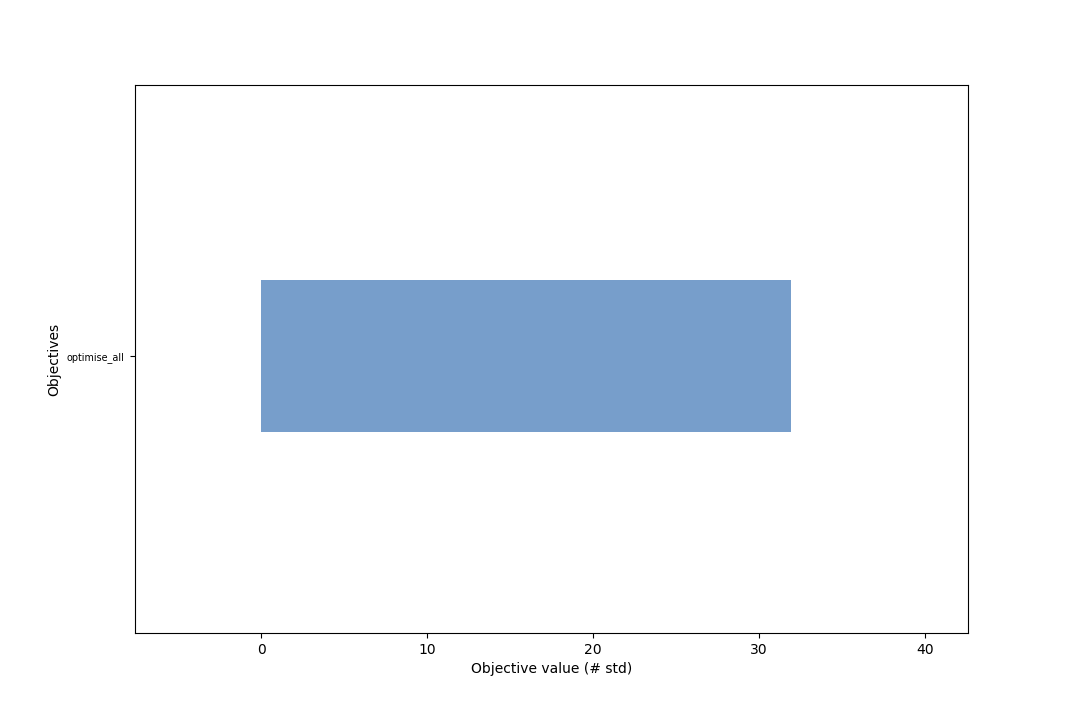

In [7]:
# Plot fitness (objective) scores
objectives = optimisation.evaluator.fitness_calculator.calculate_scores(best_responses)
plot_fitness_scores(objectives)

<IPython.core.display.Javascript object>


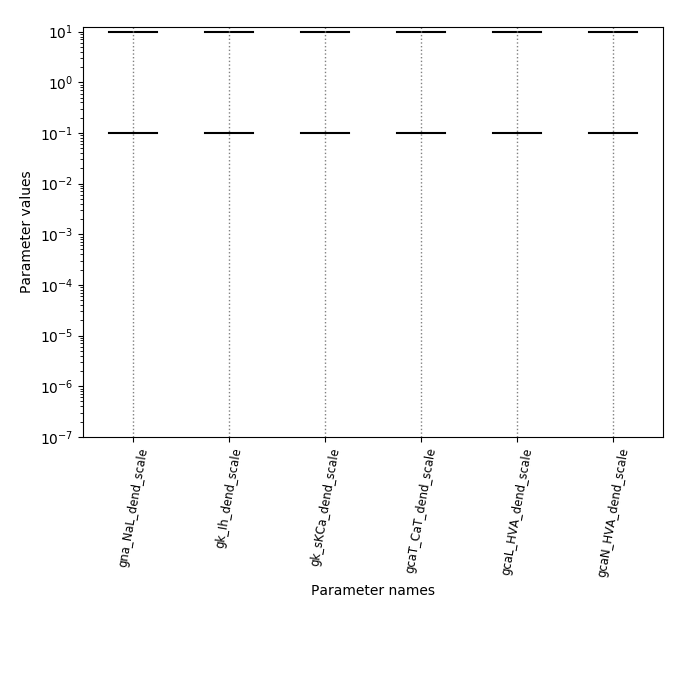

In [8]:
# Plot diversity of parameters
plot_diversity(optimisation, checkpoints_file, optimisation.evaluator.param_names)


In [ ]:
# TODO: plot responses of best candidates, and parameter variability (see l5pc example)
# TODO: use StnModuleEvaluator to evaluate other protocols
#    - first uniformize interface for setting up model and protocols
#    - also implement evaluation metrics (distance ephys)